In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt

print("Tensorflow version {}".format(tf.__version__))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.4
    Uninstalling tensorflow-datasets-4.9.4:
      Successfully uninstalled tensorflow-datasets-4.9.4
Tensorflow version 2.15.0


In [ ]:
import json
import pandas as pd
# Load the original intents JSON
with open('/content/drive/MyDrive/Dataset/qa_dataset (1).json') as file:
    data = json.load(file)
# Convert to DataFrame
df4 = pd.DataFrame(data)

# Convert 'questions_answers' column to two separate columns
df4[['question', 'answer']] = pd.json_normalize(df4['questions_answers'])

# Drop the original 'questions_answers' column
df4.drop(columns=['questions_answers'], inplace=True)

# Rename the columns if needed
df4.rename(columns={'question': 'question', 'answer': 'answer'}, inplace=True)

print(df4)

                                               question  \
0                                                 hello   
1                                                   hey   
2                                                    hi   
3                                                   cya   
4                                         see you later   
...                                                 ...   
1171  hello i'm 20 years old and i've always seemed ...   
1172  i constantly have bursts of anger for no reaso...   
1173  hello i'm 20 years old and i've always seemed ...   
1174  hello i'm 20 years old and i've always seemed ...   
1175  hello i'm 20 years old and i've always seemed ...   

                                                 answer  
0                                                 hello  
1                                                  hey!  
2                                what can i do for you?  
3                                       have a nice day  
4

In [ ]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


In [ ]:
import pandas as pd

In [ ]:

# Maximum sentence length
MAX_LENGTH = 87

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 4 * strategy.num_replicas_in_sync
BUFFER_SIZE = 10000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 8
UNITS = 256
DROPOUT = 0.1

EPOCHS = 50

In [ ]:
# Save the DataFrame as a CSV file
output_csv_path = "/content/drive/MyDrive/Dataset/df4.csv"
df4.to_csv(output_csv_path, index=False)

print("DataFrame saved as CSV successfully.")

DataFrame saved as CSV successfully.


In [ ]:
df4

,question,answer
0,hello,hello
1,hey,hey!
2,hi,what can i do for you?
3,cya,have a nice day
4,see you later,goodbye
...,...,...
1171,hello i'm 20 years old and i've always seemed ...,the description provided indicates that you mi...
1172,i constantly have bursts of anger for no reaso...,hello. from your description here it seems you...
1173,hello i'm 20 years old and i've always seemed ...,the description provided indicates that you mi...
1174,hello i'm 20 years old and i've always seemed ...,the description provided indicates that you mi...


In [ ]:
import re
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "that is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,0-9 %]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
questions = []
for i in df4.question:
  i = str(i)
  #i = preprocess_sentence(i)
  questions.append(i)

In [ ]:
answers = []
for i in df4.answer:
  i = str(i)
  #strings = i[(i.find("'answer'")) + 11:i.find("}")-1]
  #strings = preprocess_sentence(i)
  answers.append(i)



In [ ]:
print(questions[220])
print("\n")
print(answers[220])

i have had a lot of trouble getting off of narcotics (percocet and morphine my knee surgeon would give me the percocet and my family dr would give me the morphine) but this time i have actually done it. my last time using it was on new years eve. physically i am fine. mentally though i keep getting cravings for it and i try to figure out how to get more. (surgeon said if i need some go to my family doctor. family doctor would not give me anymore due to asking for refills too soon after getting a rx. ) i then tell myself "no" and then remind myself how far i have come. my question is: how long will it take for the mental withdrawl to go away? i am getting scared that i may given into one of those cravings and go to a hospital to get some. any suggestions on how to deal with this would be greatly appreciated.


given the description you could be experiencing mental dependency on narcotics. it doesnât seem that you are physically dependent on narcotics currently. in time if you donât 

In [ ]:
print(df4.question[200])

dyspnea


In [ ]:
preprocess_sentence('is 10,000 years old.')

'is 10 , 000 years old .'

In [ ]:
print(df4.answer[200])

It looks like you may have pneumothorax


In [ ]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=12000)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print(VOCAB_SIZE)

6573


In [ ]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [3294, 288, 24, 3665, 1869, 4, 68, 36, 15, 14, 4564, 6378]


In [ ]:

# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 6573
Number of samples: 415


In [ ]:
print(questions)

[[6571  728 6572 ...    0    0    0]
 [6571 5169 6572 ...    0    0    0]
 [6571 2461 6572 ...    0    0    0]
 ...
 [6571    5   29 ...    0    0    0]
 [6571 4789   50 ...    0    0    0]
 [6571  328   40 ...    0    0    0]]


In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 6573
Number of samples: 415


In [ ]:

dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
print(dataset)

<_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 87), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 86), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 86), dtype=tf.int32, name=None)})>


In [ ]:
# def scaled_dot_product_attention(query, key, value, mask):
#   """Calculate the attention weights. """
#   matmul_qk = tf.matmul(query, key, transpose_b=True)

#   # scale matmul_qk
#   depth = tf.cast(tf.shape(key)[-1], tf.float32)
#   logits = matmul_qk / tf.math.sqrt(depth)

#   # add the mask to zero out padding tokens
#   if mask is not None:
#     logits += (mask * -1e9)

#   # softmax is normalized on the last axis (seq_len_k)
#   attention_weights = tf.nn.softmax(logits, axis=-1)

#   output = tf.matmul(attention_weights, value)

#   return output

def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [ ]:
# class MultiHeadAttention(tf.keras.layers.Layer):
#     def __init__(self, d_model, num_heads, name="multi_head_attention"):
#         super(MultiHeadAttention, self).__init__(name=name)
#         self.num_heads = num_heads
#         self.d_model = d_model

#         assert d_model % self.num_heads == 0

#         self.depth = d_model // self.num_heads

#         self.query_dense = tf.keras.layers.Dense(units=d_model)
#         self.key_dense = tf.keras.layers.Dense(units=d_model)
#         self.value_dense = tf.keras.layers.Dense(units=d_model)

#         self.dense = tf.keras.layers.Dense(units=d_model)

#     def get_config(self):
#         config = super(MultiHeadAttention, self).get_config()
#         config.update({
#             'num_heads': self.num_heads,
#             'd_model': self.d_model,
#             'query_shape': self.query_shape,
#         })
#         return config

#     def split_heads(self, inputs, batch_size):
#         inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
#         return tf.transpose(inputs, perm=[0, 2, 1, 3])

#     def call(self, inputs, training=True):
#         query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
#         batch_size = tf.shape(query)[0]

#         # Linear layers
#         query = self.query_dense(query)
#         key = self.key_dense(key)
#         value = self.value_dense(value)

#         # Split heads
#         query = self.split_heads(query, batch_size)
#         key = self.split_heads(key, batch_size)
#         value = self.split_heads(value, batch_size)

#         # Scaled dot-product attention
#         scaled_attention = scaled_dot_product_attention(query, key, value, mask)
#         scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

#         # Concatenation of heads
#         concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

#         # Final linear layer
#         outputs = self.dense(concat_attention)

#         return outputs

class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [ ]:
# def create_padding_mask(x):
#   mask = tf.cast(tf.math.equal(x, 0), tf.float32)
#   # (batch_size, 1, 1, sequence length)
#   return mask[:, tf.newaxis, tf.newaxis, :]

def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

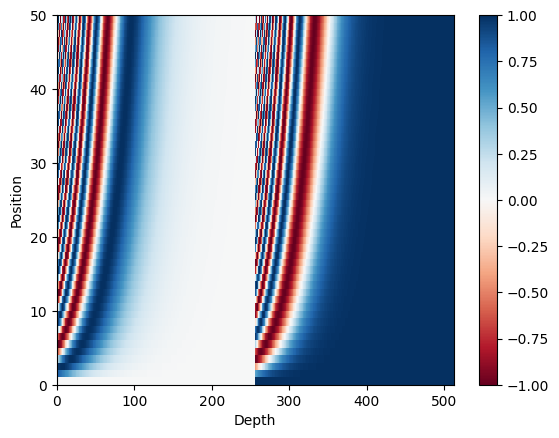

In [ ]:
# sample_pos_encoding = PositionalEncoding(position=50, vocab_size=50, d_model=512, name='sample_pos_encoding_layer')
# plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
# plt.xlabel('Depth')
# plt.xlim((0, 512))
# plt.ylabel('Position')
# plt.colorbar()
# plt.show()


sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

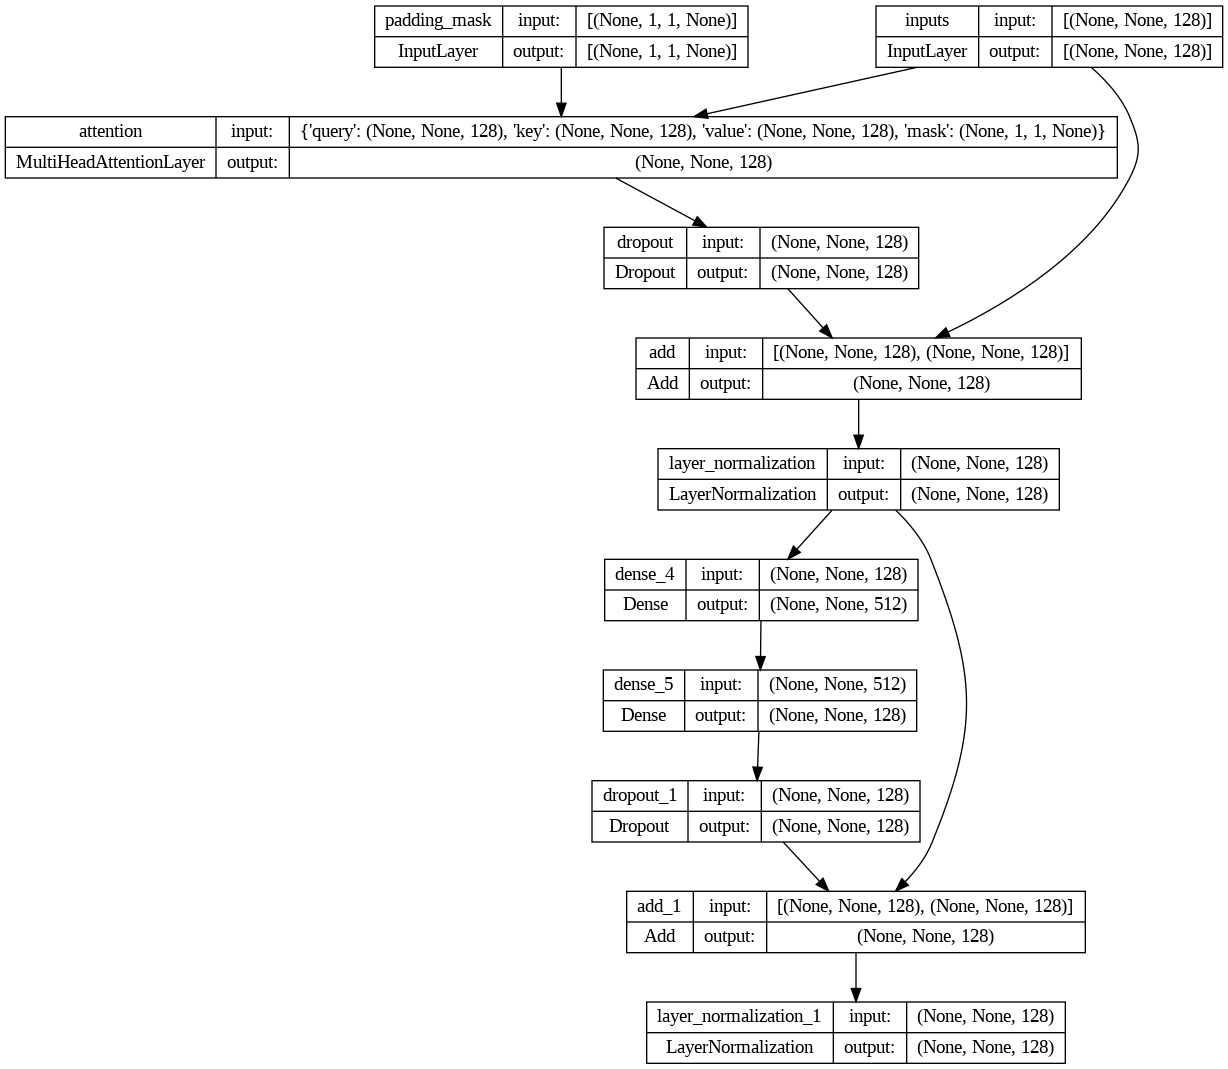

In [ ]:
sample_encoder_layer = encoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_encoder_layer"
)

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file="encoder_layer.png", show_shapes=True
)

In [ ]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

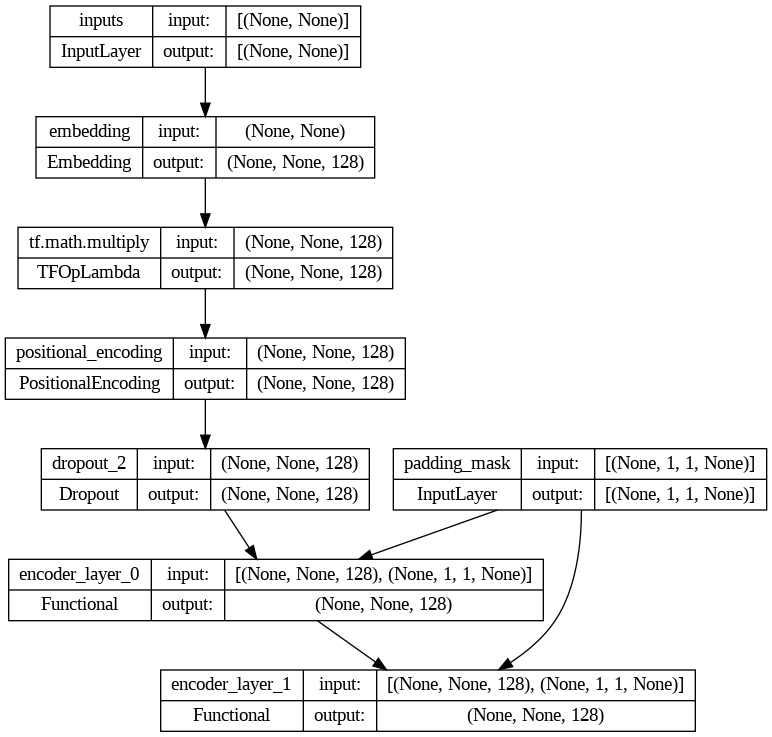

In [ ]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder",
)

tf.keras.utils.plot_model(sample_encoder, to_file="encoder.png", show_shapes=True)

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

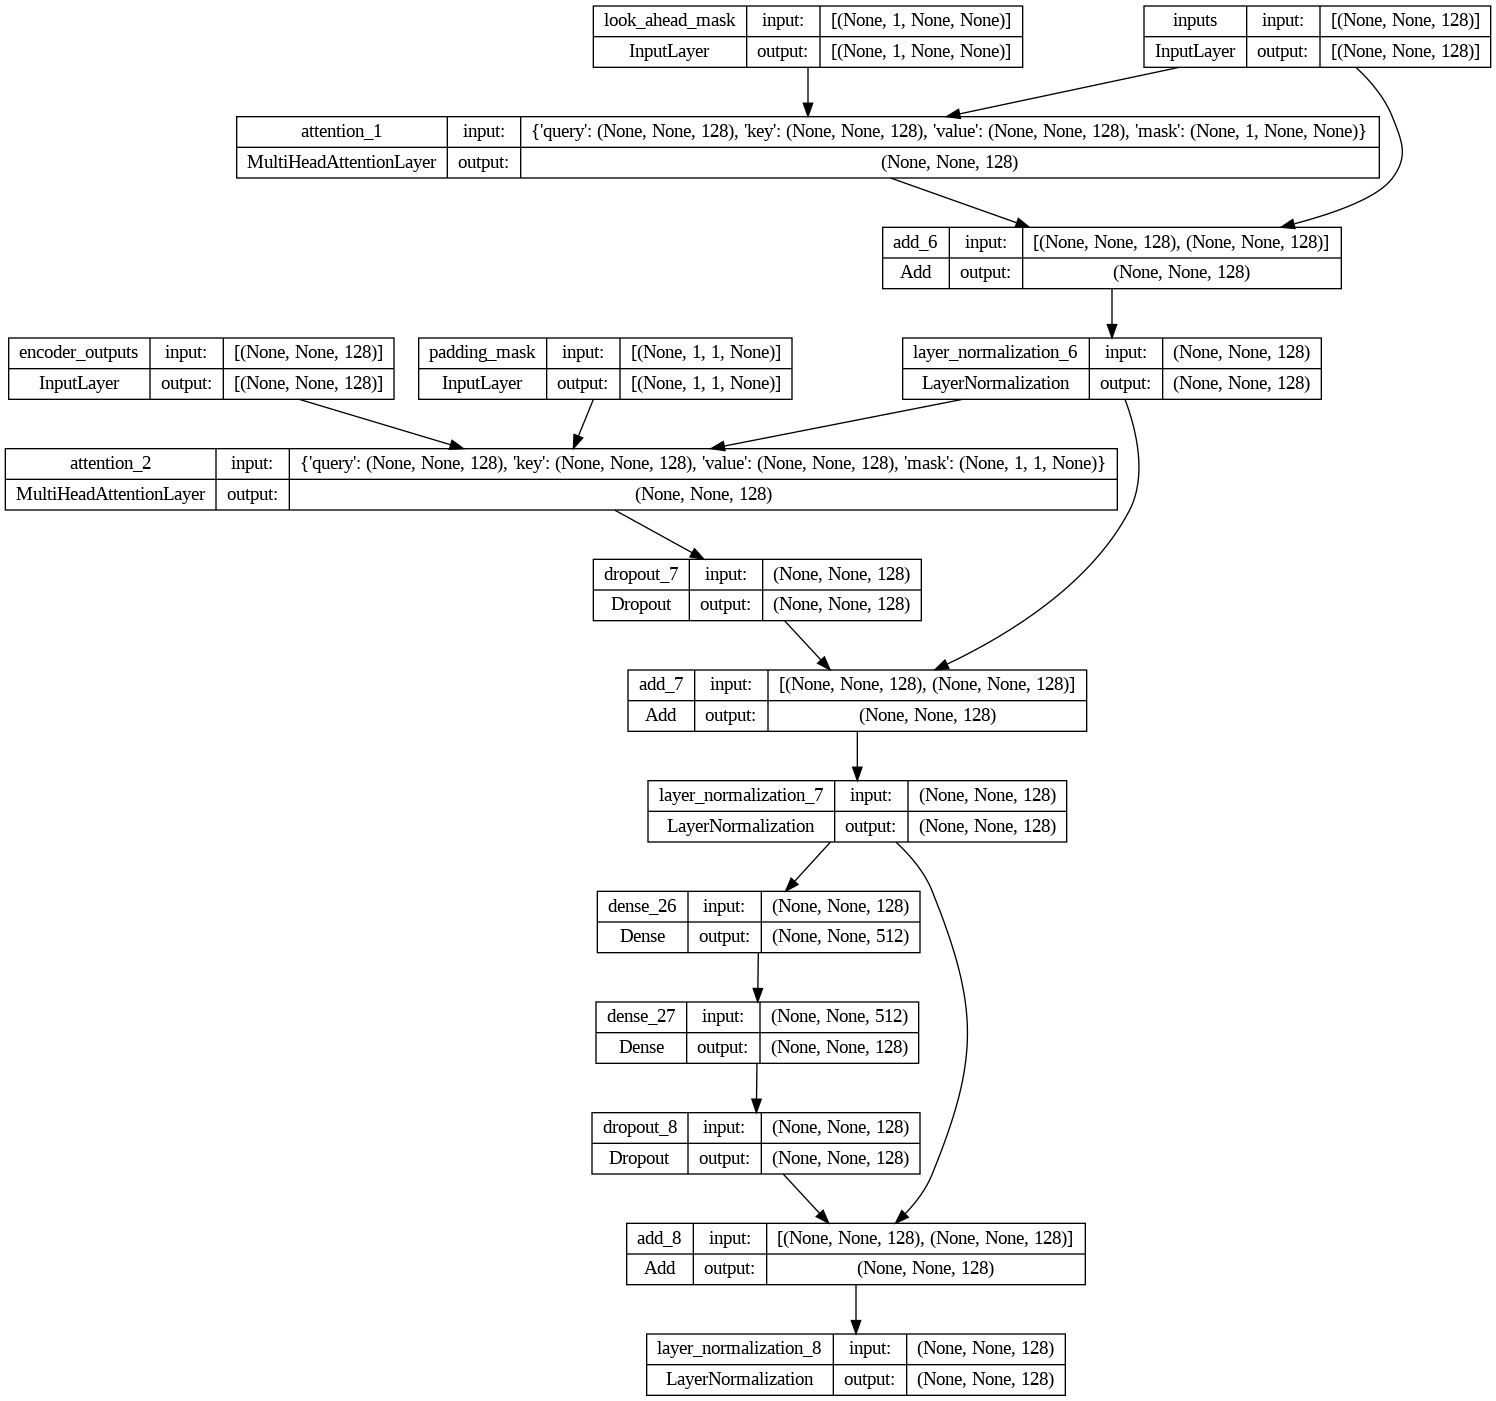

In [ ]:
sample_decoder_layer = decoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_decoder_layer"
)

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file="decoder_layer.png", show_shapes=True
)

In [ ]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

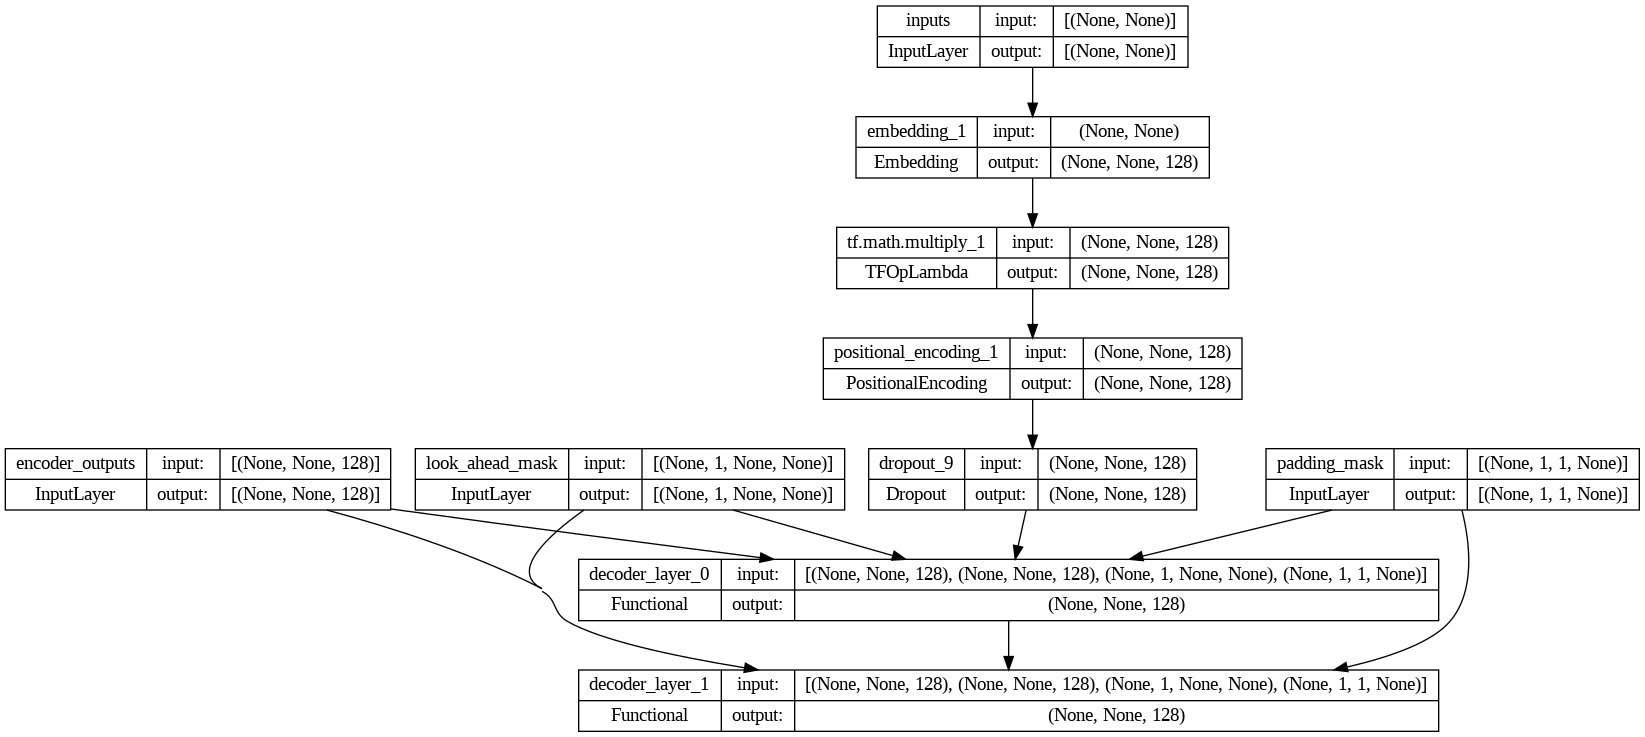

In [ ]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder",
)

tf.keras.utils.plot_model(sample_decoder, to_file="decoder.png", show_shapes=True)

In [ ]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

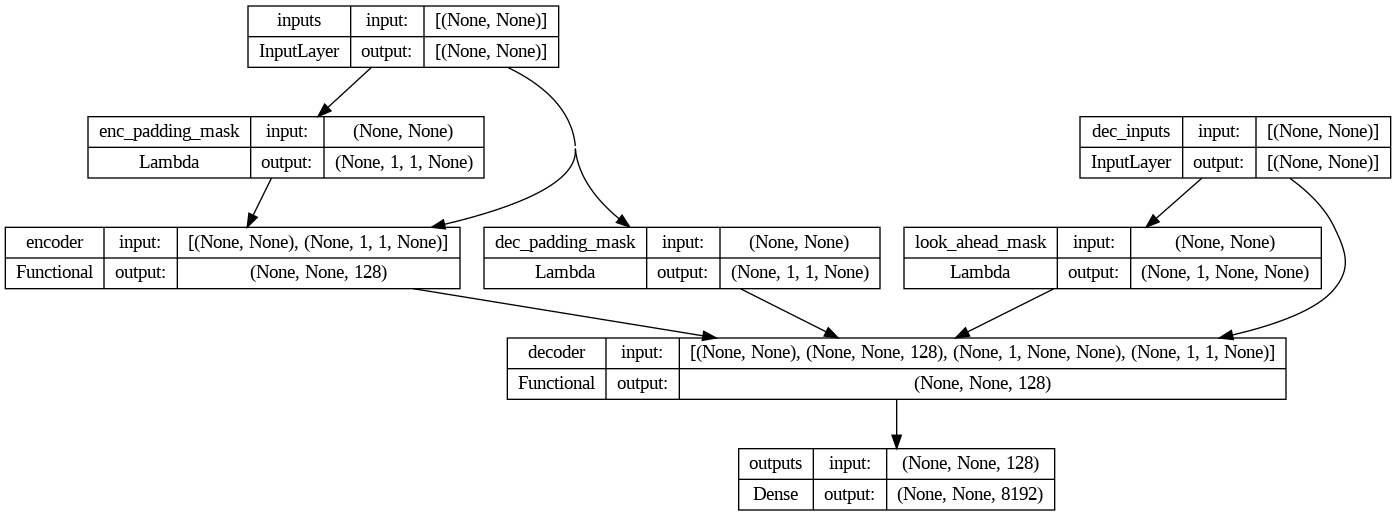

In [ ]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer",
)

tf.keras.utils.plot_model(
    sample_transformer, to_file="transformer.png", show_shapes=True
)

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [ ]:

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

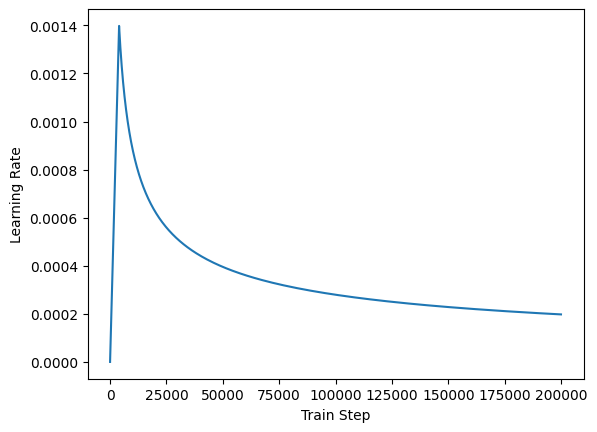

In [ ]:


sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:

tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 512)            5996544   ['inputs[0][0]',              
                                                                     'enc_padding_mask[0

In [ ]:
model.fit(dataset,epochs=100)

Epoch 1/100
104/104 [==============================] - 81s 639ms/step - loss: 4.1749 - accuracy: 0.0125
Epoch 2/100
104/104 [==============================] - 67s 641ms/step - loss: 3.6230 - accuracy: 0.0207
Epoch 3/100
104/104 [==============================] - 69s 664ms/step - loss: 3.0795 - accuracy: 0.0342
Epoch 4/100
104/104 [==============================] - 67s 647ms/step - loss: 2.6806 - accuracy: 0.0693
Epoch 5/100
104/104 [==============================] - 67s 643ms/step - loss: 2.2476 - accuracy: 0.1172
Epoch 6/100
104/104 [==============================] - 67s 647ms/step - loss: 1.7707 - accuracy: 0.1991
Epoch 7/100
104/104 [==============================] - 67s 642ms/step - loss: 1.3171 - accuracy: 0.2965
Epoch 8/100
104/104 [==============================] - 67s 642ms/step - loss: 0.9368 - accuracy: 0.3605
Epoch 9/100
104/104 [==============================] - 68s 656ms/step - loss: 0.6559 - accuracy: 0.3996
Epoch 10/100
104/104 [==============================] - 66s 632m

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')  # Mount your Google Drive

# local_model_path = '/content/drive/MyDrive/Colab Notebooks/Models1/transformer_model/my_model.h5'  # Replace with your desired path
# model.save(local_model_path)

filename = "/content/drive/MyDrive/Models/my_model2.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)


<ipython-input-53-eea962b9d352>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)


In [ ]:
del model
tf.keras.backend.clear_session()

In [ ]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Models/my_model2.h5",
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
    },
    compile=False,
)

In [ ]:
import tensorflow as tf


def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # Select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # Return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # Concatenate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    return predicted_sentence

print("Hi! I am MedBot. How can I help you?")

while True:
    message = input("You: ")
    if message.lower() == 'bye':
        print("MedBot: Goodbye! Have a great day.")
        break

    predicted_sentence = predict(message)
    print("MedBot:", predicted_sentence)


Hi! I am MedBot. How can I help you?
You: hi
MedBot: what can i do for you?
You: what is your name
MedBot: you can call me Medbot!
You: i have fever
MedBot: It looks like you may have acquired immuno-deficiency syndrome
You: immuno deficiency 
MedBot: It looks like you may have depression mental
You: fever medicines
MedBot: sputum cultures should be sent for sensitivity to the standard and second line drugs. the fever should also be documented. you didnt specify if you were 4 months along with the initiation or continuation phase alone of treatment. whether you are on two drugs or four drugs. wishing you best of health thanks
You: medicines for fever
MedBot: over-the-counter medications such as dimenhydrinate (Dramamine), meclizine (Bonine), or bismuth subsalicylate (Pepto-Bismol) can help relieve symptoms of motion sickness or nausea. Prescription medications like ondansetron (Zofran) or promethazine (Phenergan) may be prescribed for more severe cases of nausea and vomiting, such as t

In [ ]:
output = predict("who should i contact for consultation?")

'confusion [unused299] [unused41] more [unused136] [unused28] [unused8] [unused66] [unused19] [unused32] [unused121] single [SEP] ᶜ [unused18] ষ [unused2] ு [unused2] [unused21] [unused514] by [unused52] [unused977] [unused0] [unused27] [unused8] [unused22] [unused106] [unused188] [unused87] 馬 [unused18] ষ [unused2] ு [unused954] [unused0] [unused27] [unused8] [unused16] [unused410] everything [unused87] [unused359] [unused12] ர [unused26] [unused92] [unused129] [unused136] [unused14] [unused271] [unused53] 2018 ς د ᅢ [unused361] [unused175] [unused632] station [unused0] [unused81] [unused20] [unused89] [unused0] [unused32] [unused76] milk'

In [ ]:
predict("i am shivering")

'abortion the clinical way of stopping an unplanned/unprepared/unhealthy pregnancy.'

In [ ]:
print(output)

abortion the clinical way of stopping an unplanned/unhealthy pregnancy.


In [ ]:
output = predict("What is you name")

In [ ]:
output = predict("hi i am sudarshan. i am a cp child(spastic diplegia). i have completed my computer engg from pune university and currently pursuing mba. i wish to learn driving? i have been practising for 6 months with vain. these are the problems that i face: 1. there is difficulty in releasing the clutch and pressing the accelerator at the same time. 2. the gear handling is also difficult with steering. 3. thirdly i have a somewhat poor road sense. how these can be improved.")

In [ ]:
output = predict("What medicines can I buy to help me with my diabetes?")

In [ ]:
output = predict("What medicines can I buy to help me with my depression?")

Input: What medicines can I buy to help me with my depression?
Output: medicines you can consume :  brexpiprazole, quetiapine,olanzapine, prevention that you must follow :Exercise regularly,Cut back on social media time,Drink Water as Your Primary Beverage,Build strong relationships,Minimize your daily choices, Follow a Very-Low-Carb Diet,SUGGESTED FOODS ARE:Get Enough Vitamin D,Include Omega-3 Fatty Acids,Beans and legumes
